In [1]:
from hh_parser_functions import *

# Анализ рынка труда
Скачивает данные с hh.ru, строит по ним графики.  
Замените вакансии в ячейке 2 на те, что интересуют вас, затем запустите все ячейки тетради.  
(контекстное меню сверху "Cell" -> выбрать "Run All")

In [2]:
job_list = ['data scientist', 
            'web разработчик', 
            'python программист', 
            'бизнес аналитик']

В ячейке 3 можно поменять максимальное число обрабатываемых вакансий для каждого запроса, чтобы набор данных был сбалансированным. Также можно изменить регион поиска (если поле оставлено пустым, в качестве исследуемого региона будет выступать вся Россия)

In [3]:
max_samples = 400     # максимальное число обрабатываемых вакансий
area = ''             # регион поиска вакансий

За процессом загрузки вакансий с сайта можно следить в ячейке ниже. 

In [4]:
job_data, tfidf_data = download_data(job_list, area, max_samples)

data scientist
web разработчик
python программист
бизнес аналитик


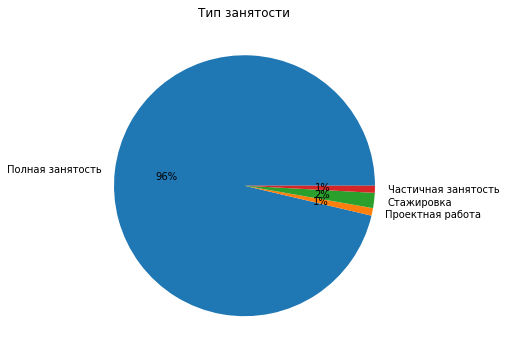

In [5]:
draw_employment_pie_chart(job_data)

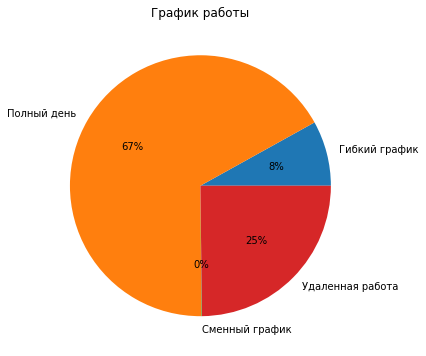

In [6]:
draw_schedule_pie_chart(job_data)

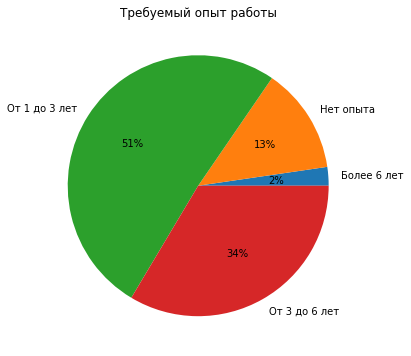

In [7]:
draw_experience_pie_chart(job_data)

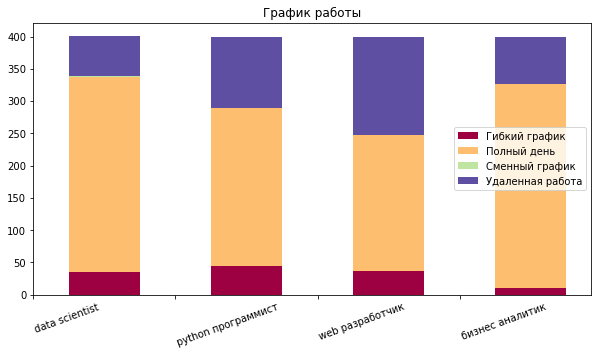

In [8]:
draw_schedule_histogram(job_data)

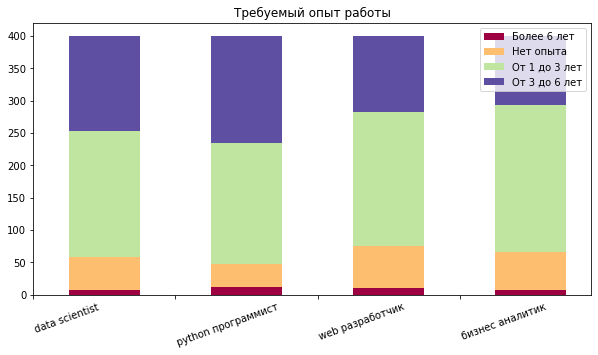

In [9]:
draw_experience_histogram(job_data)

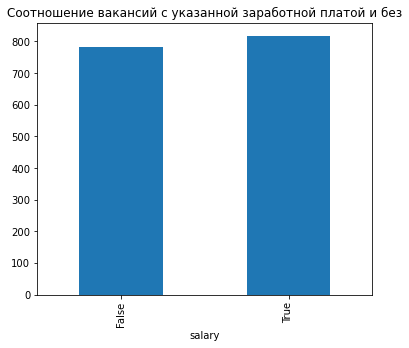

In [10]:
draw_salary_ratio(job_data)

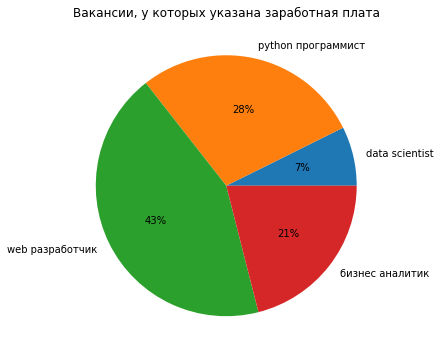

In [11]:
draw_salary_pie_chart(job_data)

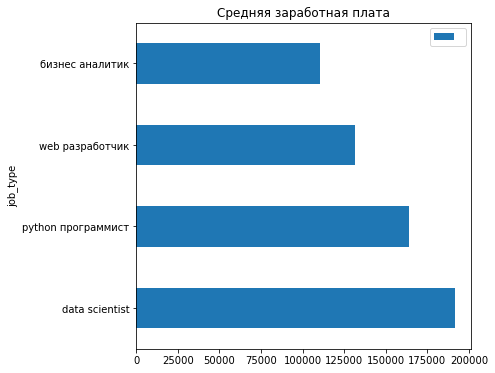

In [12]:
draw_salary_histogram(job_data)

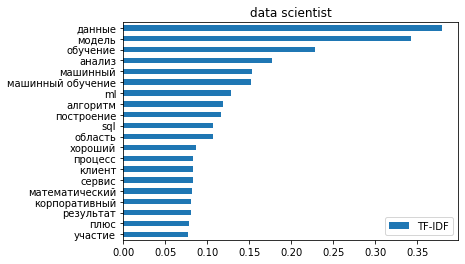

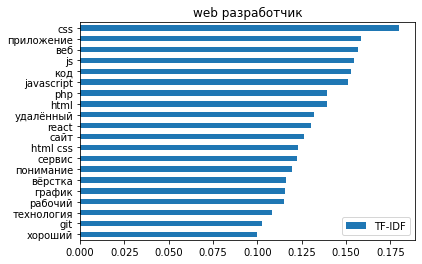

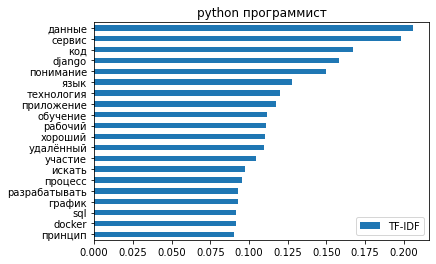

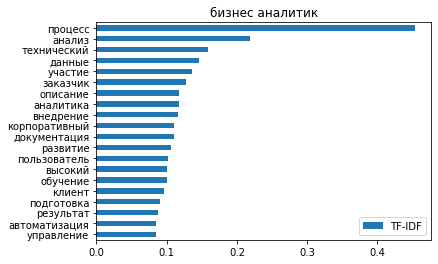

In [13]:
draw_tfidf_histogram(tfidf_data, job_list)